<a href="https://colab.research.google.com/github/PetiteBeast/pytorch_style_transfer/blob/master/Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install torch torchvision
!pip install Pillow==4.0.0

     |████████████████████████████████| 2.1MB 6.6MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


  Using cached https://files.pythonhosted.org/packages/37/e8/b3fbf87b0188d22246678f8cd61e23e31caa1769ebc06f1664e2e5fe8a17/Pillow-4.0.0-cp36-cp36m-manylinux1_x86_64.whl
ERROR: torchvision 0.4.2 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
ERROR: scikit-image 0.15.0 has requirement pillow>=4.3.0, but you'll have pillow 4.0.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 6.2.1
    Uninstalling Pillow-6.2.1:
      Successfully uninstalled Pillow-6.2.1


In [0]:
%matplotlib inline
import torch
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


In [0]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
  param.requires_grad_(False)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [0]:
def load_image(img_path, max_size=400, shape=None):
  image = Image.open(img_path).convert('RGB')
  if max(image.size) > max_size:
    size = max_size
  else:
    size = max(image.size)
    
  if shape is not None:
    size = shape
    
  print(size)
  
  in_transform = transforms.Compose([
      transforms.Resize(size),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), 
                           (0.5, 0.5, 0.5))
  ])
  
  image = in_transform(image).unsqueeze(0)
  return image

In [13]:
!wget https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg
!wget https://i.ytimg.com/vi/MPV2METPeJU/maxresdefault.jpg
content = load_image('maxresdefault.jpg').to(device)
style = load_image('The_Great_Wave_off_Kanagawa.jpg', shape=content.shape[-2:]).to(device)

--2019-12-01 18:39:58--  https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2684586 (2.6M) [image/jpeg]
Saving to: ‘The_Great_Wave_off_Kanagawa.jpg.1’

The_Great_Wave_off_ 100%[===================>]   2.56M  --.-KB/s    in 0.1s    

2019-12-01 18:39:58 (25.8 MB/s) - ‘The_Great_Wave_off_Kanagawa.jpg.1’ saved [2684586/2684586]

--2019-12-01 18:40:01--  https://i.ytimg.com/vi/MPV2METPeJU/maxresdefault.jpg
Resolving i.ytimg.com (i.ytimg.com)... 108.177.15.119, 2a00:1450:400c:c0b::77
Connecting to i.ytimg.com (i.ytimg.com)|108.177.15.119|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72972 (71K) [image/jpeg]
Saving to: ‘maxresdefault.jpg.1’

maxresdefault.jpg.1 100%[===================>]  71.26K

In [0]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.squeeze()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0,1)
  return image

(-0.5, 710.5, 399.5, -0.5)

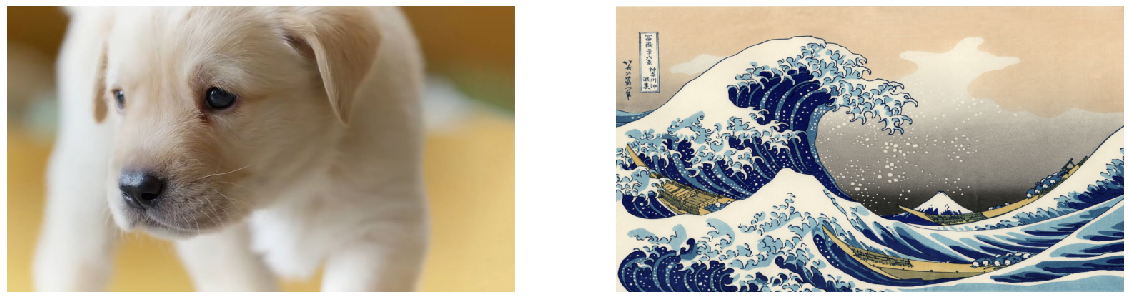

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off')

In [0]:
def get_features(image, model):
  layers = {'0': 'conv1_1',
           '5': 'conv2_1',
           '10': 'conv3_1',
           '19': 'conv4_1',
           '21': 'conv4_2', # content_extraction
           '28': 'conv5_1'}
  
  features = {}
  
  for name, layer in model._modules.items():
    image = layer(image)
    if name in layers:
      features[layers[name]] = image
  
  return features
  

In [0]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

In [0]:
def gram_matrix(tensor):
  # b - batch size, not used further
  b, d, h, w = tensor.size()
  tensor = tensor.view(d, h*w)
  gram = torch.mm(tensor, tensor.t())
  return gram

In [0]:
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

In [0]:
style_weights = {'conv1_1': 1.,
                'conv2_1': 0.75,
                'conv3_1': 0.2,
                'conv4_1': 0.2,
                'conv5_1': 0.2}

content_weight = 1 # alpha
style_weight = 1e6 # beta

In [0]:
target = content.clone().requires_grad_(True).to(device)

In [0]:
show_every = 300
optimizer = optim.Adam([target], lr = 0.003)
steps = 2100 # 10000 is great, but it's faster and we could see effects

height, width, channels = im_convert(target).shape
image_array = np.empty(shape = (300, height, width, channels))

capture_frame = steps/300
counter = 0

Total loss:  7933009.5
Iteration:  300


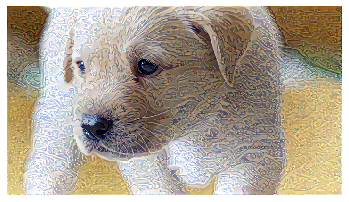

Total loss:  2443156.25
Iteration:  600


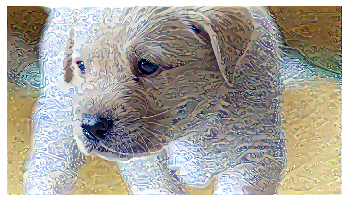

Total loss:  1184902.375
Iteration:  900


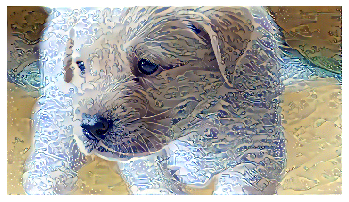

Total loss:  758688.375
Iteration:  1200


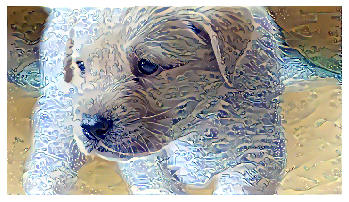

Total loss:  546263.625
Iteration:  1500


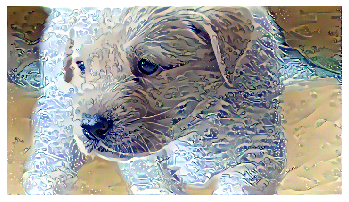

Total loss:  419429.5625
Iteration:  1800


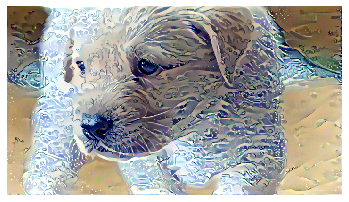

Total loss:  336232.78125
Iteration:  2100


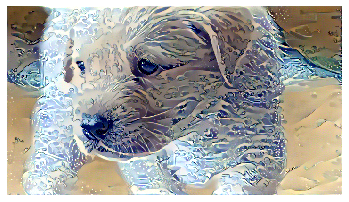

In [23]:
for ii in range(1, steps + 1):
  target_features = get_features(target, vgg)
  content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
  style_loss = 0
  
  for layer in style_weights:
    target_feature = target_features[layer]
    target_gram = gram_matrix(target_feature)
    style_gram = style_grams[layer]
    layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
    _, d, h, w = target_feature.shape
    style_loss += layer_style_loss / (d*h*w) # normalize
  
  total_loss = content_loss*content_weight + style_loss*style_weight
  
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()
  
  if ii % show_every == 0:
    print('Total loss: ', total_loss.item())
    print('Iteration: ', ii)
    plt.imshow(im_convert(target))
    plt.axis('off')
    plt.show()
    
  if ii % capture_frame == 0:
    image_array[counter] = im_convert(target)
    counter += 1
  

(-0.5, 710.5, 399.5, -0.5)

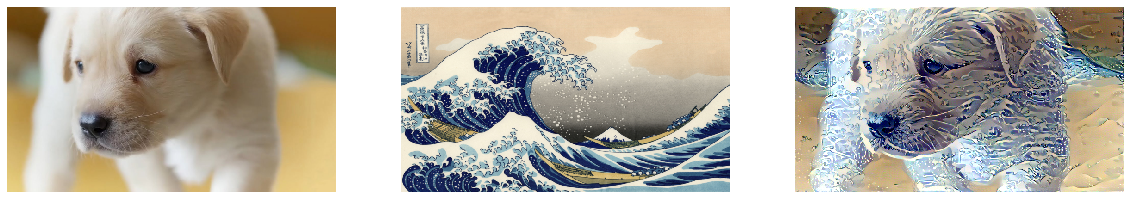

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off')
ax3.imshow(im_convert(target))
ax3.axis('off')

In [0]:
import cv2

frame_height, frame_width, _ = im_convert(target).shape
vid = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'XVID'), 30, (frame_width, frame_height))

for i in range(0, 300):
  img = image_array[i]
  img = img*255
  img = np.array(img, dtype = np.uint8)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  vid.write(img)

vid.release()